In [34]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run runme_terminus_sensitivity_basic.m tutorial translted from Matlab to Python
# Mikayla Pascual 06/16/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

In [14]:
# Setup
region = 'SAtoES';
start_year = 1985;

# Mesh sizing
triangleresolution = 1000;

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution) # set up mesh

savevars('./Models/' +region+ '_mesh', 'md', md)


# 

Shelving variables to new file './Models/SAtoES_mesh'.
Variable 'md' shelved.


/efs/issm/issm/trunk-jpl/src/m/plot/plotmodel.py:123: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axgrid = ImageGrid(


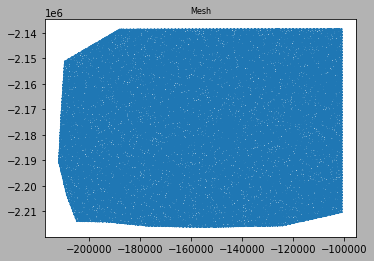

In [15]:
# Plot mesh
plotmodel(md,'data','mesh')

In [37]:
# Step 3
## Inversion
md = loadmodel('./Models/' +region+ '_Param.mat');
# Control general
md.inversion=m1qn3inversion(md.inversion);
md.inversion.iscontrol=1;
md.verbose=verbose('solution',false,'control',true);

# Cost functions
md.inversion.cost_functions=[101,103,501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=ones(md.mesh.numberofvertices,length(md.inversion.cost_functions));
md.inversion.cost_functions_coefficients[:,1]=2000;
md.inversion.cost_functions_coefficients[:,2]=40;
md.inversion.cost_functions_coefficients[:,3]=1.6e-06;

#Where vel==0, set coefficients to 0 (i.e., don't try to match this in model
disp(['Removing vel==0 obs from inversion']);
pos = find(md.inversion.vel_obs == 0);
md.inversion.cost_functions_coefficients[pos,1] = 0;
md.inversion.cost_functions_coefficients[pos,2] = 0;

#Controls
md.inversion.control_parameters={'FrictionCoefficient'};
md.inversion.maxsteps=50;
md.inversion.maxiter =50;
md.inversion.min_parameters=0.05*ones(md.mesh.numberofvertices,1);
md.inversion.max_parameters=200*ones(md.mesh.numberofvertices,1);
md.inversion.control_scaling_factors=1;

#Set basal friction coefficient initial guess to something low at front
filename = ['Exp/' +region+ '_coeffront.exp'];
if os.path.exists(filename,'file'):
  disp(['Correcting basal friction coefficient initial guess for front inconsistencies']);
  flags = ContourToNodes(md.mesh.x,md.mesh.y,filename,2);
  %flags = md.inversion.vel_obs == 0;
  pos1 = find(flags); pos2 = find(~flags);
  md.friction.coefficient[pos1,:] = 10;

  md.inversion.max_parameters[pos1] = md.friction.coefficient[pos1,:];
end

#Additional parameters
md.stressbalance.restol=0.01;
md.stressbalance.reltol=0.1;
md.stressbalance.abstol=NaN;
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

# Go solve
md.verbose.solution=1;
md.cluster = cluster;
md.settings.waitonlock = waitonlock;
md = solve(md,'Stressbalance');

# Save
savemodel(org,md);

Opening ./Models/SAtoES_Param.mat for reading 


AttributeError: NetCDF: Attribute not found